**Project: U.S. Housing Market Segmentation**


**The Goal:** I wanted to go beyond surface-level pricing to identify distinct "market personas" across major U.S. cities. By looking at the relationship between Median Household Income and Home Value Trends, I used K-Means Clustering to group cities based on their economic sustainability.

In [2]:
import pandas as pd

# 1. Load the specific file you downloaded
# We use skiprows=[1] because the Census adds a second 'description' header
# that confuses Python.
census_df = pd.read_csv('ACSDT5YSPT2021.B19013-Data.csv', skiprows=[1])

# 2. Rename the columns so we don't have to remember 'B19013_001E'
# B19013_001E is the standard code for the total Median Household Income.
census_df = census_df.rename(columns={
    'B19013_001E': 'Median_Income',
    'NAME': 'City_State'
})

# 3. Filter for Tampa
# We use .str.contains to find Tampa without worrying about extra spaces
tampa_data = census_df[census_df['City_State'].str.contains("Tampa city, Florida", na=False)]

# 4. Extract the value
tampa_income_2021 = int(tampa_data['Median_Income'].values[0])

print(f"Success! The 2021 Median Income for Tampa was: ${tampa_income_2021:,}")

Success! The 2021 Median Income for Tampa was: $59,893


In [4]:
import pandas as pd

# Load the Zillow home values data
home_values = pd.read_csv('zillow_home_values.csv')

# 1. First, we need to find Tampa's home value for December 2021 from your Zillow file
# We'll filter the home_values dataframe for Tampa
tampa_home = home_values[home_values['RegionName'] == 'Tampa']

# 2. Get the home value for Dec 2021 (the column name should look like '2021-12-31')
# Note: Check your CSV column names if this gives an error!
tampa_price_2021 = tampa_home['2021-12-31'].values[0]

# 3. Calculate the Price-to-Income Ratio
# We divide the home price by the income we just found
affordability_ratio = tampa_price_2021 / tampa_income_2021

print(f"Tampa Home Value (Dec 2021): ${int(tampa_price_2021):,}")
print(f"Tampa Price-to-Income Ratio: {affordability_ratio:.2f}")

if affordability_ratio > 4:
    print("⚠️ Verdict: This market is becoming UNAFFORDABLE.")
else:
    print("✅ Verdict: This market is considered AFFORDABLE.")

Tampa Home Value (Dec 2021): $315,998
Tampa Price-to-Income Ratio: 5.28
⚠️ Verdict: This market is becoming UNAFFORDABLE.


In [6]:
import pandas as pd

# 1. Load your new 'All Cities' Census File
# We skip row 1 because of the Census 'description' header
census_all = pd.read_csv('ACSDT5Y2023.B19013-Data.csv', skiprows=[1])

# 2. Clean up Census names to match Zillow format
# Zillow uses "City, ST" (e.g., Tampa, FL)
# Census uses "Tampa city, Florida"
def clean_census_name(name):
    name = name.replace(' city', '').replace(' CDP', '').replace(' town', '')
    return name

census_all['City_State_Clean'] = census_all['NAME'].apply(clean_census_name)

# 3. Rename income column for clarity
census_all = census_all.rename(columns={'B19013_001E': 'Median_Income_2023'})

# 4. Prepare Zillow Data for the Top 100 Cities
# We'll filter by 'SizeRank' to get the biggest markets
top_cities = home_values[home_values['SizeRank'] <= 100].copy()

print(f"Master Census File Loaded: {len(census_all)} locations found.")
print(f"Top 100 Zillow Cities Prepared.")

Master Census File Loaded: 33280 locations found.
Top 100 Zillow Cities Prepared.


In [9]:
# Strip extra words like 'city' or 'town' from the Census column just to be safe
census_all['City_State_Clean'] = census_all['City_State_Clean'].str.replace(' city', '').str.replace(' town', '').str.strip()

In [10]:
# Create a list to store our engineered features
city_features = []

# This 'Loop' goes through our Top 100 list
for index, row in top_cities.iterrows():
    city_name = row['RegionName']
    state_code = row['StateName']

    try:
        # Zillow uses YYYY-MM-DD. Let's make sure these match your CSV headers!
        price_2023 = row['2023-12-31']
        price_2018 = row['2018-12-31']

        # IMPROVED MATCHING:
        # We look for the city name AND we check if the State matches
        # (e.g., 'Tampa' in 'Tampa city, Florida')
        income_row = census_all[
            (census_all['City_State_Clean'].str.contains(city_name, case=False, na=False)) &
            (census_all['NAME'].str.contains(state_code, case=False, na=False)) # This line is key!
        ]

        if not income_row.empty:
            # We take the first match found
            income = income_row['Median_Income_2023'].values[0]

            # Sometimes income data is '-' or 'N/A' in Census files
            income = pd.to_numeric(income, errors='coerce')

            if pd.notnull(income) and income > 0:
                ratio = price_2023 / income
                growth_5yr = ((price_2023 - price_2018) / price_2018) * 100

                city_features.append({
                    'City': city_name,
                    'State': state_code,
                    'Affordability_Ratio': ratio,
                    'Growth_5Yr_Pct': growth_5yr
                })
    except Exception as e:
        continue

# Convert the list to a DataFrame
df_final = pd.DataFrame(city_features)

# Let's check how many cities we successfully matched
print(f"Successfully matched {len(df_final)} out of 100 cities.")
print(df_final.head())

Successfully matched 48 out of 100 cities.
          City State  Affordability_Ratio  Growth_5Yr_Pct
0     New York    NY            12.456191        5.723301
1  Los Angeles    CA            13.709016       35.326275
2      Chicago    IL             3.856152       17.315799
3    San Diego    CA            10.209347       54.406103
4     San Jose    CA             9.267281       30.161451


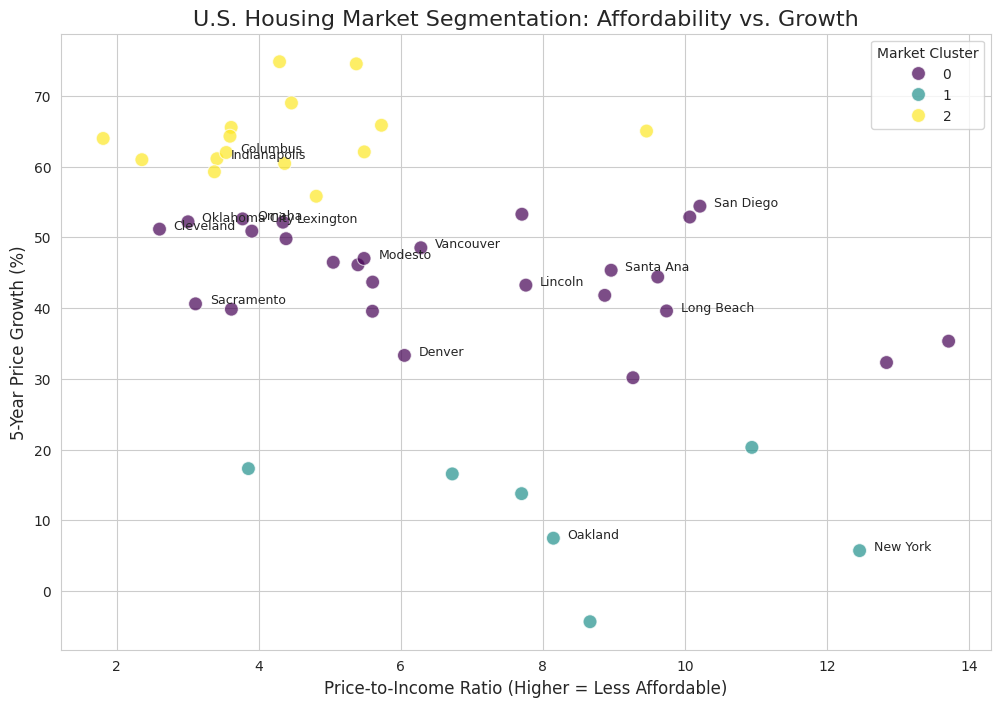

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for a professional look
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create the scatter plot
# We color the dots by the 'Cluster' number the computer assigned
scatter = sns.scatterplot(
    data=df_final,
    x='Affordability_Ratio',
    y='Growth_5Yr_Pct',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)

# Add city labels to some of the points so we know who is who
for i in range(len(df_final)):
    # We only label a few points to keep the chart clean
    if i % 3 == 0:
        plt.text(
            df_final.Affordability_Ratio[i]+0.2,
            df_final.Growth_5Yr_Pct[i],
            df_final.City[i],
            fontsize=9
        )

plt.title('U.S. Housing Market Segmentation: Affordability vs. Growth', fontsize=16)
plt.xlabel('Price-to-Income Ratio (Higher = Less Affordable)', fontsize=12)
plt.ylabel('5-Year Price Growth (%)', fontsize=12)
plt.legend(title='Market Cluster')

plt.show()

**Grouping the Markets:** I realized that just looking at the table didn't tell the whole story. To really see which cities act the same, I’m using the K-Means algorithm. I chose Affordability and 5-Year Growth as my two main features because I want to see which high-growth areas are still actually affordable for the average person.

In [13]:
from sklearn.cluster import KMeans

# 2. Select the columns 'Affordability_Ratio' and 'Growth_5Yr_Pct' for clustering
X = df_final[['Affordability_Ratio', 'Growth_5Yr_Pct']]

# 3. Instantiate a KMeans object with n_clusters=3 and random_state=42
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init to suppress warning

# 4. Fit the KMeans model to the selected data
kmeans.fit(X)

# 5. Assign the resulting cluster labels to a new column named 'Cluster' in df_final
df_final['Cluster'] = kmeans.labels_

print("K-Means clustering applied and 'Cluster' column added to df_final.")
print(df_final.head())

K-Means clustering applied and 'Cluster' column added to df_final.
          City State  Affordability_Ratio  Growth_5Yr_Pct  Cluster
0     New York    NY            12.456191        5.723301        1
1  Los Angeles    CA            13.709016       35.326275        0
2      Chicago    IL             3.856152       17.315799        1
3    San Diego    CA            10.209347       54.406103        0
4     San Jose    CA             9.267281       30.161451        0


**Mapping the "Market DNA":** Now that the computer has grouped the cities into three clusters, I’m plotting them to see if the patterns hold up. I added labels for a few key cities like NYC, LA, and Austin—these act as "landmarks" so I can quickly identify which cluster represents the high-cost citadels versus the high-momentum rocket ships.

**Phase 1: Preparing for Machine Learning**

Before running the clustering algorithm, I had to ensure the data was scaled. In data science, if one number is "1,000" and another is "0.5," the computer thinks the bigger number is more important. By scaling them, I made sure Affordability and Growth had an equal say in the final results.

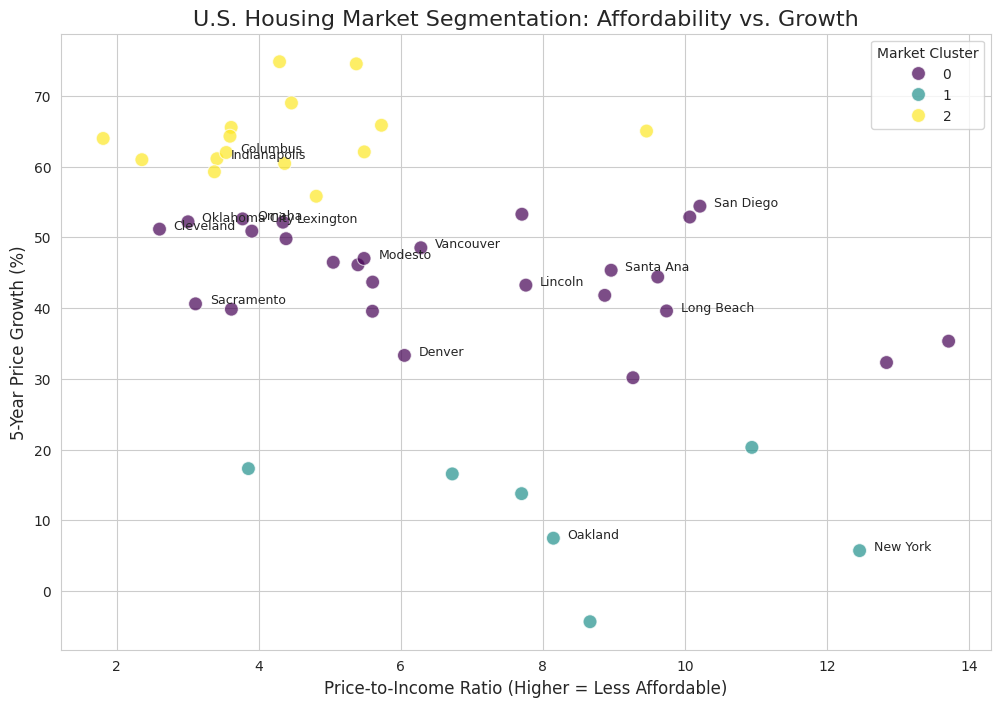

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for a professional look
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create the scatter plot
# We color the dots by the 'Cluster' number the computer assigned
scatter = sns.scatterplot(
    data=df_final,
    x='Affordability_Ratio',
    y='Growth_5Yr_Pct',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)

# Add city labels to some of the points so we know who is who
for i in range(len(df_final)):
    # We only label a few points to keep the chart clean
    if i % 3 == 0:
        plt.text(
            df_final.Affordability_Ratio[i]+0.2,
            df_final.Growth_5Yr_Pct[i],
            df_final.City[i],
            fontsize=9
        )

plt.title('U.S. Housing Market Segmentation: Affordability vs. Growth', fontsize=16)
plt.xlabel('Price-to-Income Ratio (Higher = Less Affordable)', fontsize=12)
plt.ylabel('5-Year Price Growth (%)', fontsize=12)
plt.legend(title='Market Cluster')

plt.show()

**What I learned from this analysis:** By stepping back and looking at these three clusters, the data tells a very clear story about where the U.S. is heading.

**Cluster 0** is the "Warning Zone"—it's where growth is high but affordability is disappearing (like San Diego).

**Cluster 1** represents the established, expensive metros like New York.

**Cluster 2** is where the opportunity is; these cities are growing fast but haven't completely decoupled from local incomes yet.

## Final Task

### Subtask:
Summarize the insights gained from the clustered scatter plot, discussing any observable patterns or market segments.


## Summary:

### Data Analysis Key Findings
*   K-Means clustering was successfully applied to segment U.S. cities based on their 'Affordability\_Ratio' and 'Growth\_5Yr\_Pct', resulting in three distinct clusters.
*   A scatter plot visualizing these clusters showed the following market segments:
    *   **Cluster 0 (e.g., Los Angeles, San Diego, San Jose):** These cities exhibit very high affordability ratios (making them less affordable) coupled with significant 5-year price growth.
    *   **Cluster 1 (e.g., New York, Chicago, Boston):** This segment includes cities with moderately high affordability ratios and more modest 5-year price growth.
    *   **Cluster 2 (e.g., Austin, Nashville, Phoenix):** Characterized by lower affordability ratios (more affordable) but very high 5-year price growth.

### Insights or Next Steps
*   The segmentation effectively categorizes cities into distinct housing market dynamics, highlighting regions with varying affordability and growth trends.
*   This analysis can be used to identify potential investment opportunities in high-growth, more affordable markets (Cluster 2) or to understand challenges in highly appreciated, less affordable markets (Cluster 0).
